# KNN Model

### Dataset Information
No. of Features: 12   
No. of Instances: 4492

## Table of Contents<a name='table of contents'></a>

1. [Data Ingestion](#data ingestion)
2. [Features & Target Arrays](#features and target arrays)
3. [Hyperparameter Tuning](#hyperparameter tuning)  
    a. [Model Complexity Curve](#model complexity curve)  
    b. [GridSearchCV](#gridsearchcv)
4. [Classification Report](#classification report)
5. [Confusion Matrix](#confusion matrix)
6. [Class Balance](#class balance)
7. [Save Model](#pickle)

In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import yellowbrick as yb
sns.set_palette('RdBu', 10)

## Data Ingestion<a name='data ingestion'></a>

In [2]:
URL = 'https://raw.githubusercontent.com/georgetown-analytics/classroom-occupancy/master/models/sensor_data_ml.csv'

def fetch_data(fname='sensor_data_ml.csv'):
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Defining fetching data from the URL
DATA = fetch_data()

In [3]:
# Import sensor data
df = pd.read_csv('sensor_data_ml.csv', index_col='datetime', parse_dates=True)

In [4]:
# Rename columns
df.columns = ['temp', 'humidity', 'co2', 'light', 'light_st', 'noise',
              'bluetooth', 'images', 'door', 'occupancy_count', 'occupancy_level']

In [5]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4492 entries, 2017-03-25 09:05:00 to 2017-06-10 16:47:00
Data columns (total 11 columns):
temp               4492 non-null float64
humidity           4492 non-null float64
co2                4492 non-null float64
light              4492 non-null float64
light_st           4492 non-null float64
noise              4492 non-null float64
bluetooth          4492 non-null float64
images             4492 non-null float64
door               4492 non-null float64
occupancy_count    4492 non-null float64
occupancy_level    4492 non-null object
dtypes: float64(10), object(1)
memory usage: 421.1+ KB


,temp,humidity,co2,light,light_st,noise,bluetooth,images,door,occupancy_count
count,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000
mean,23.130643,39.474289,1235.613327,414.313558,0.900749,292.690467,219.644525,13.397958,0.184636,23.934357
std,1.401324,6.480433,182.745597,530.373407,0.295897,175.343505,139.619955,5.640015,0.357883,9.981144
min,21.000000,21.100000,653.000000,138.294355,0.000000,30.777778,0.000000,1.982398,0.000000,0.000000
25%,22.358333,37.725000,1102.000000,178.577454,1.000000,143.750000,116.562500,10.053533,0.000000,24.000000
50%,22.900000,39.747917,1262.541667,209.916667,1.000000,144.333333,190.000000,12.106858,0.000000,28.416667
75%,23.208333,44.600000,1366.876596,383.343828,1.000000,501.087889,301.833333,15.876286,0.083333,30.000000
max,29.350000,50.566667,1606.973185,2891.583333,1.000000,576.208035,635.000000,64.560408,1.000000,31.000000


### Features & Target Arrays<a name='features and target arrays'></a>

In [6]:
# Breakdown of classroom occupancy levels
df.occupancy_level.value_counts()

high         2881
mid-level     781
empty         482
low           348
Name: occupancy_level, dtype: int64

In [7]:
# Encode multiclass target variable
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit_transform(df['occupancy_level'])

array([0, 0, 2, ..., 2, 2, 2], dtype=int64)

In [13]:
# Create feature and target arrays
X = df.drop('occupancy_level', axis=1).values
y = df['occupancy_level']

In [14]:
# Use TimeSeriesSplit to create training and test set split indices
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=12)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## kNN Classifier<a name='knn'></a>

#### Cross-Validation Score<a name='first cv scores'></a>

In [15]:
# Initial cross-validation scores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Create a KNeighborsClassifier object: knn
knn = KNeighborsClassifier().fit(X_train, y_train)

# Print the 12-fold cross-validation scores
cv_scores = cross_val_score(knn, X_train, y_train, cv=tscv)
print(cv_scores)
print('Average 12-Fold CV Score: {:.4f}'.format(np.mean(cv_scores)))

[ 0.75862069  0.56426332  0.82131661  0.62695925  0.32288401  0.21003135
  0.48902821  0.71473354  0.66144201  0.62382445  0.56426332  0.54858934]
Average 12-Fold CV Score: 0.5755


In [16]:
# Initial classification report
from sklearn.metrics import classification_report

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Predict the labels of the test set: y_pred
y_pred = knn.predict(X_test)

# Compute and print the classification report and training and test scores
print('kNN Classification Report: \n{}'.format(classification_report(y_test, y_pred)))
print('Training set score: {:.4f}'.format(knn.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(knn.score(X_test, y_test)))

kNN Classification Report: 
             precision    recall  f1-score   support

      empty       0.91      0.25      0.39        85
       high       0.80      0.95      0.87       654
        low       0.92      0.62      0.74       141
  mid-level       0.73      0.70      0.72       243

avg / total       0.81      0.80      0.78      1123

Training set score: 0.9270
Test set score: 0.8005


## Hyperparameter Tuning<a name='hyperparameter tuning'></a>

#### kNN Model Complexity Curve<a name='model complexity curve'></a>

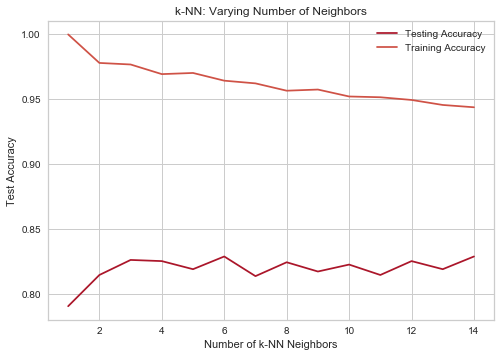

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

neighbors = np.arange(1, 15)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    pipeline = Pipeline([('scaler', RobustScaler()),
                         ('knn', KNeighborsClassifier(n_neighbors=k))])
    
    # Fit the classifier to the training data
    pipeline.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = pipeline.score(X_train, y_train)
    
    #Compute accuracy on the testing set
    test_accuracy[i] = pipeline.score(X_test, y_test)

# Plot the results
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Accuracy')
plt.title('k-NN: Varying Number of Neighbors')
plt.xlabel('Number of k-NN Neighbors')
plt.ylabel('Test Accuracy')
plt.legend(loc='best')
plt.savefig('ml_graphs/knn_model_complexity_curve.png')

### GridSearchCV<a name='gridsearchcv'></a>

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

pipeline = make_pipeline(RobustScaler(), KNeighborsClassifier())

param_grid = {'kneighborsclassifier__n_neighbors': np.arange(1, 15)}

knn = GridSearchCV(pipeline, param_grid=param_grid, cv=tscv)

knn.fit(X_train, y_train)

print('kNN Best estimator:\n{}'.format(knn.best_estimator_))

kNN Best estimator:
Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform'))])


In [20]:
# Print the tuned parameters and score by accessing the best_params_ and best_score_ attributes of grid
print('kNN Model (Tuned)')
print('Best Score: {:.4f}'.format(knn.best_score_))
print('Best Parameters: {}'.format(knn.best_params_))

kNN Model (Tuned)
Best Score: 0.7300
Best Parameters: {'kneighborsclassifier__n_neighbors': 4}


#### kNN Classification Report<a name='classification report'></a>

In [21]:
# Predict the labels of the test set: y_pred
y_pred = knn.predict(X_test)

print('kNN Classification Report: \n{}'.format(classification_report(y_test, y_pred)))
print('Training set score: {:.4f}'.format(knn.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(knn.score(X_test, y_test)))

kNN Classification Report: 
             precision    recall  f1-score   support

      empty       0.62      1.00      0.77        85
       high       0.85      0.96      0.90       654
        low       0.92      0.63      0.75       141
  mid-level       0.82      0.52      0.63       243

avg / total       0.84      0.83      0.81      1123

Training set score: 0.9694
Test set score: 0.8255


In [22]:
# Compare f1 scores based on different averaging strategies
from sklearn.metrics import f1_score

print('F1 Score - micro: {:.4f}'.format(f1_score(y_test, y_pred, average='micro')))
print('F1 Score - weighted: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))
print('F1 Score - macro: {:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

F1 Score - micro: 0.8255
F1 Score - weighted: 0.8149
F1 Score - macro: 0.7635


In [24]:
from sklearn.metrics import precision_score, recall_score

print('Micro')
print('F1 Score: {:.4f}'.format(f1_score(y_test, y_pred, average='micro')))
print('Precision Score: {:.4f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Recall Score: {:.4f}'.format(recall_score(y_test, y_pred, average='micro')))

Micro
F1 Score: 0.8255
Precision Score: 0.8255
Recall Score: 0.8255


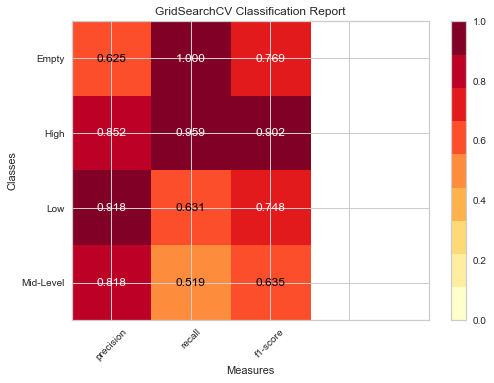

In [27]:
from yellowbrick.classifier import ClassificationReport
classes = ['Empty', 'High', 'Low', 'Mid-Level']

visualizer = ClassificationReport(knn, classes=classes)

fig = plt.figure()
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
#plt.savefig('ml_graphs/knn_classification_report.png')

#### Confusion Matrix<a name='confusion matrix'></a>

In [29]:
from sklearn.metrics import confusion_matrix

print('kNN Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

kNN Confusion Matrix
[[ 85   0   0   0]
 [  0 627   0  27]
 [ 51   0  89   1]
 [  0 109   8 126]]


#### Class Balance<a name='class balance'></a>

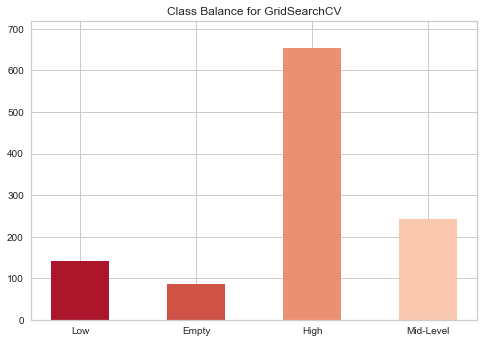

In [28]:
from yellowbrick.classifier import ClassBalance
classes = ['Empty', 'High', 'Low', 'Mid-Level']

visualizer = ClassBalance(knn, classes=classes)

fig = plt.figure()
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
#plt.savefig('ml_graphs/knn_class_balance.png')

## Save Model<a name='pickle'></a>

In [31]:
import pickle

knn_model = 'knn_model.sav'

# Save fitted model to disk
pickle.dump(knn, open(knn_model, 'wb'))

### [Return to Table of Contents](#table of contents)

In [32]:
loaded_model = pickle.load(open(knn_model, 'rb'))

result = loaded_model.score(X_test, y_test)
print(result)

0.825467497774
